In [1]:
#!/home/akhanal1/Spring2018/pl-env/bin/python3.5
import os
os.chdir("c:\\Projects\\ature")
import sys
import path_config as pth
import numpy as np
import itertools as itr
from random import shuffle
from commons.segmentation import AtureTestMat, AtureTest
from PIL import Image as IMG

sep = os.sep
data_file_path = pth.DATA_PATH + sep + 'DRIVE' + sep + 'test' + sep + 'images'
av_data = pth.DATA_PATH + sep + 'av_wide_data_set'

mask_path = pth.DATA_PATH + sep + 'DRIVE' + sep + 'test' + sep + 'mask'
ground_truth_path = pth.DATA_PATH + sep + 'DRIVE' + sep + 'test' + sep + '1st_manual'

# for ubuntu
sys.path.append(pth.CONTEXT_PATH)
os.chdir(pth.CONTEXT_PATH)


def get_mask_file(file_name): return file_name.split('_')[0] + '_test_mask.gif'


def get_ground_truth_file(file_name): return file_name.split('_')[0] + '_manual1.gif'


SK_THRESHOLD_PARAMS = np.arange(40, 61, 20)
ALPHA_PARAMS = np.arange(5, 7, 0.5)
GABOR_CONTRIBUTION_PARAMS = np.arange(0.6, 1.1, 0.2)
SEGMENTATION_THRESHOLD_PARAMS = np.arange(9, 15, 0.5)

PARAMS_ITR = itr.product(SK_THRESHOLD_PARAMS, ALPHA_PARAMS, GABOR_CONTRIBUTION_PARAMS, SEGMENTATION_THRESHOLD_PARAMS)

PARAMS_COMBINATION = list(PARAMS_ITR)
shuffle(PARAMS_COMBINATION)

keys = ('sk_threshold', 'alpha', 'gabor_contrib', 'seg_threshold')

all_params = list(dict(zip(keys, param)) for param in PARAMS_COMBINATION)

params = {'sk_threshold': 60,
          'alpha': 5.5,
          'gabor_contrib': 1,
          'seg_threshold': 9.0}

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
### Run for image files with in-time mask erosion
tester = AtureTest(data_dir=data_file_path, out_dir=os.path.join(pth.OUT_PATH, 'out_new'))
tester.load_mask(mask_dir=mask_path, fget_mask_file=get_mask_file, erode_mask=True)
tester.load_ground_truth(ground_truth_dir=ground_truth_path, fget_ground_truth_file=get_ground_truth_file)
acc = tester.run_for_one_image(file_name='16_test.tif', params=params, save_images=True, epochs=2, alpha_decay=0.4)
# tester.run_for_all_images(params_combination=all_params)


### Run for mask fixed by Dr. Estrada
# mask_path = pth.DATA_PATH + sep + 'DRIVE' + sep + 'test' + sep + 'mask_fixed'
# tester = AtureTest(data_dir=data_file_path, out_dir=os.path.join(pth.OUT_PATH, 'out_rj'))
# tester.load_mask(mask_dir=mask_path, fget_mask_file=get_mask_file, erode_mask=False)
# tester.load_ground_truth(ground_truth_dir=ground_truth_path, fget_ground_truth_file=get_ground_truth_file)
# tester.run_for_one_image(file_name='01_test.tif', params=params, save_images=True)
# tester.run_for_all_images(params_combination=all_params)

## Run for mat files in av_wide_data_set dir
# tester = AtureTestMat(data_dir=av_data, out_dir=os.path.join(pth.OUT_PATH, 'out_ak'))
# tester.load_mask(mask_dir=mask_path, fget_mask_file=get_mask_file)
# tester.load_ground_truth(ground_truth_dir=ground_truth_path, fget_ground_truth_file=get_ground_truth_file)
# acc = tester.run_for_one_image(file_name='wide_image_03.mat', params=params,save_images=True)

### File loaded: 16_test.tif
Mask loaded: 16_test_mask.gif
Ground truth loaded: 16_manual1.gif
Lattice created
@checktime: Function  "_initialize(__)"  took 4.361 seconds.
Running epoch: 0
Filter applied
@checktime: Function  "_segment_now(__)"  took 105.511 seconds.
@checktime: Function  "_calculate_scores(__)"  took 5.377 seconds.
@checktime: Function  "_generate_rgb(__)"  took 3.628 seconds.
@checktime: Function  "_generate_rgb(__)"  took 3.247 seconds.
Number of params combination tried: 1
Running epoch: 1
@checktime: Function  "_disable_segmented_vessels(__)"  took 1.152 seconds.
Filter applied
@checktime: Function  "_segment_now(__)"  took 28.867 seconds.
@checktime: Function  "_calculate_scores(__)"  took 6.024 seconds.
@checktime: Function  "_generate_rgb(__)"  took 3.872 seconds.
@checktime: Function  "_generate_rgb(__)"  took 3.906 seconds.
Number of params combination tried: 2


In [ ]:
import pandas as pd
df =pd.read_csv('out/segmentation_result.csv')

In [ ]:
df = df.query('FILE_NAME=="16_test.tif"')

In [ ]:
grouped = df.groupby(['SK_THRESHOLD','ALPHA','GABOR_CONTRIB','SEG_THRESHOLD']).mean().reset_index()
grouped_sorted = grouped.sort_values(by='FSCORE', ascending=False)

In [ ]:
grouped_sorted.head()

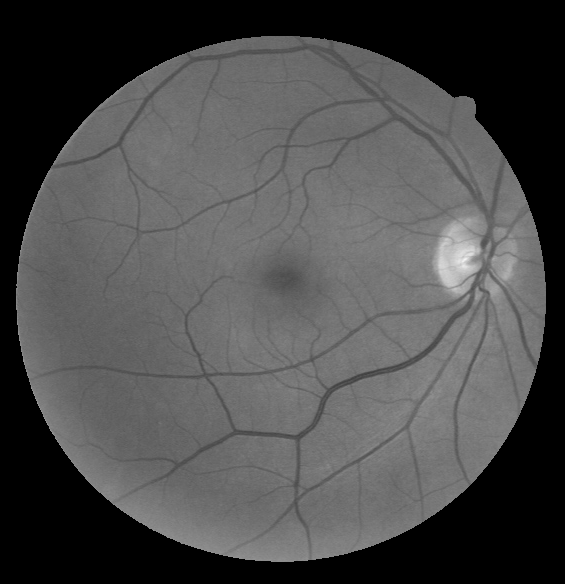

In [5]:
IMG.fromarray(acc.res['image0'])

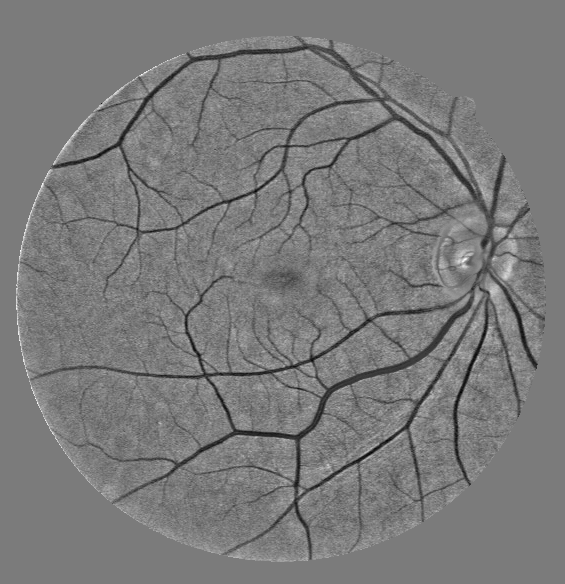

In [6]:
IMG.fromarray(acc.res['bilateral0'])

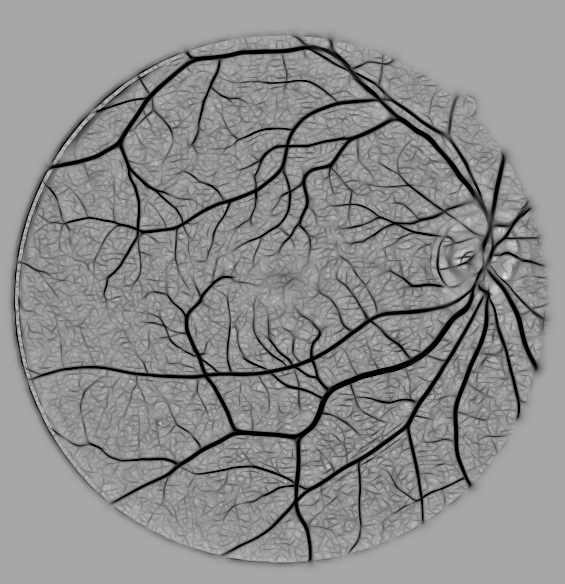

In [7]:
IMG.fromarray(acc.res['gabor0'])

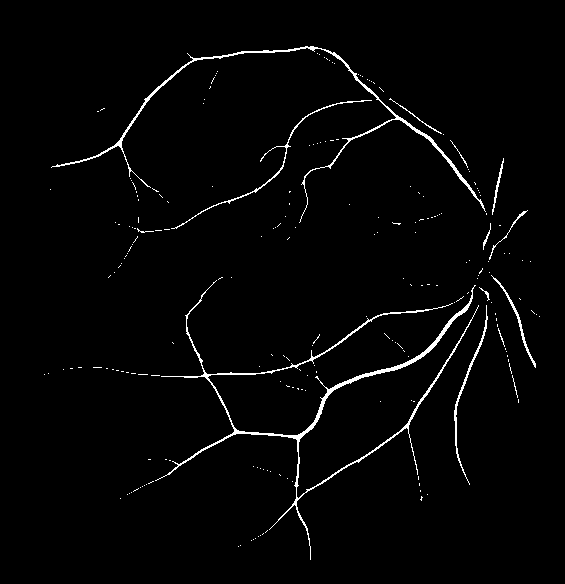

In [9]:
IMG.fromarray(255-acc.res['skeleton0'])

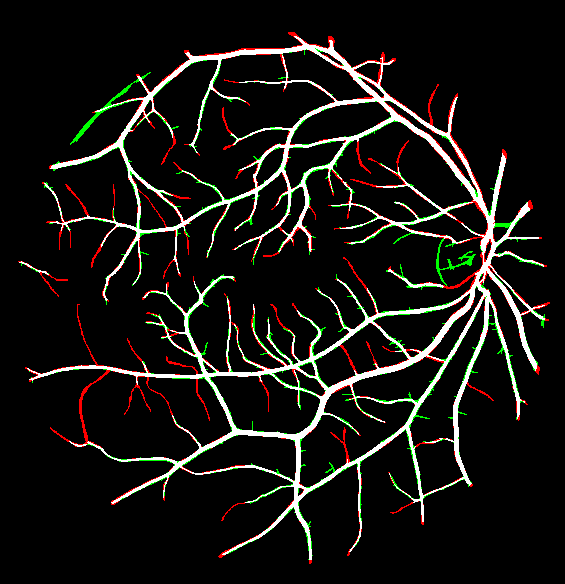

In [8]:
IMG.fromarray(acc.res['segmented0'])

In [10]:
print(acc.res['scores0'])
print(acc.res['scores1'])

{'Precision': 0.8256289811750471, 'Recall': 0.7787922526937666, 'Accuracy': 0.9651775972845194, 'F1': 0.8015269812754784}
{'Precision': 0.7849566055930569, 'Recall': 0.7923869625054547, 'Accuracy': 0.9616559582979756, 'F1': 0.7886542830415608}


In [27]:
print(acc.res['params0'])
print(acc.res['params1'])

{'sk_threshold': 60, 'alpha': 5.5, 'gabor_contrib': 1, 'seg_threshold': 9.0}
{'sk_threshold': 60, 'alpha': 5.1, 'gabor_contrib': 1, 'seg_threshold': 9.0}


In [ ]:
# Second round segmentation starts from here

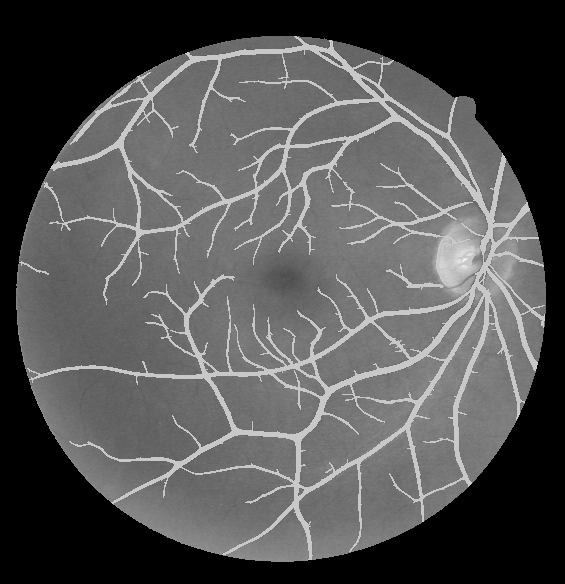

In [13]:
IMG.fromarray(acc.res['image1'])

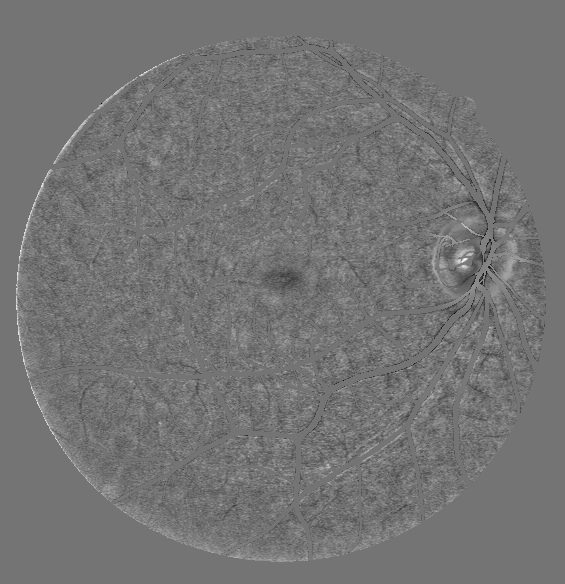

In [14]:
IMG.fromarray(acc.res['bilateral1'])

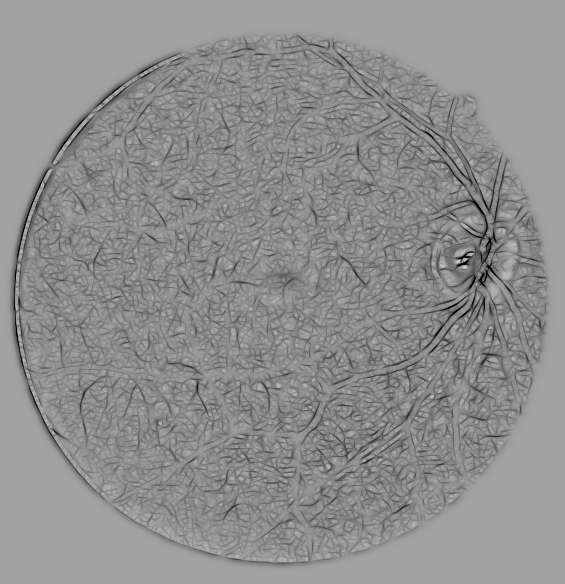

In [15]:
IMG.fromarray(acc.res['gabor1'])

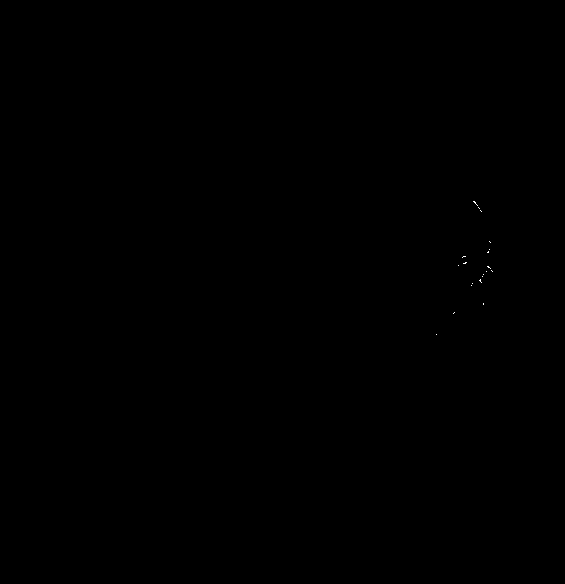

In [18]:
IMG.fromarray(255-acc.res['skeleton1'])

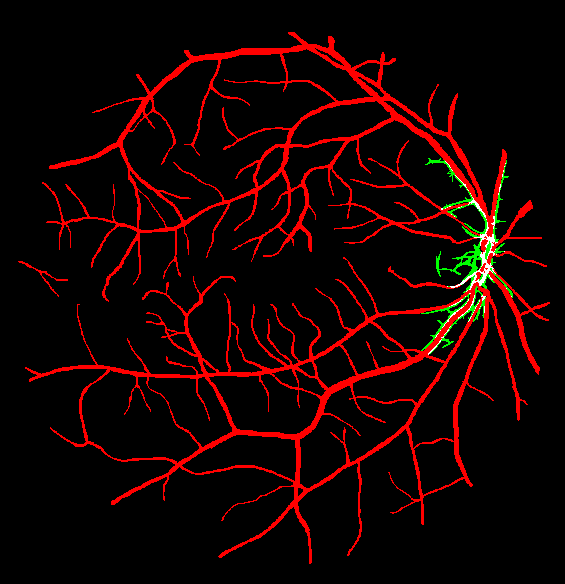

In [20]:
IMG.fromarray(acc.res['segmented1'])

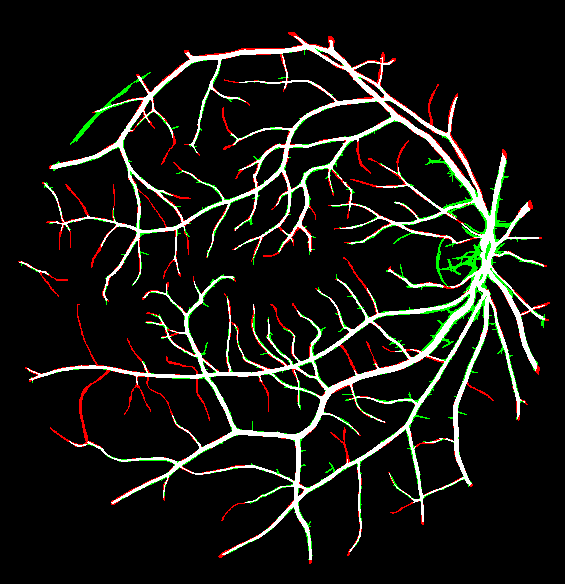

In [21]:
IMG.fromarray(acc.arr_rgb)

In [22]:
import preprocess.utils.img_utils as ig

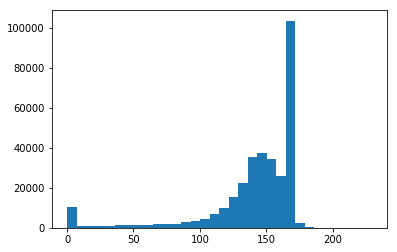

In [25]:
ig.histogram(acc.res['gabor0'])

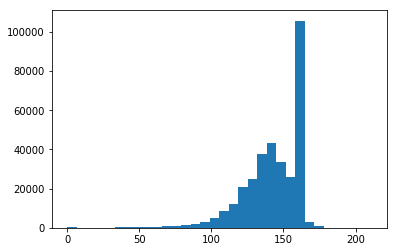

In [26]:
ig.histogram(acc.res['gabor1'])